In [1]:
import pandas as pd

# Load Data

In [2]:
# %%time 
# #6min 11s
# # load data using chunksize option
# df_chunks = pd.read_json('../data/yelp_dataset/review.json', lines=True, chunksize=400000)

# # list to hold chunks after querying
# chunks = [chunk[((chunk.stars == 5.0) | (chunk.stars == 1.0)) & (chunk.useful > 0)] for chunk in df_chunks]

# # dataframe of useful 5-star reviews
# df = pd.concat(chunks)

# # save csv for faster loading in the future
# df.to_csv('../data/pos_neg_reviews.csv')

In [2]:
df = pd.read_csv('../data/pos_neg_reviews.csv', usecols=['stars', 'text', 'useful'])

In [3]:
df_copy = df.copy()

# One-Hot Encode the Target (5 Stars ==> 0,  1 Star ==> 1)

In [4]:
df.loc[(df.stars == 5), 'stars'] = 0

# EDA

In [5]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

In [8]:
# create tfidf matrix for training set

# limit documents or computer will freeze.
df_sample = df.sample(frac=1/20, weights=df['stars']+1, random_state=1151)

# AND/OR #

# limit features or computer will freeze.
max_features = 1000


vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
df_tr_vect = vectorizer.fit_transform(df_sample.text)
features = vectorizer.get_feature_names()

In [9]:
# get indices of words with highest tfidf values

# make sure to limit features above or computer will freeze.

pos_features = df_tr_vect.toarray()[df_sample['stars']==0].mean(axis=0)
neg_features = df_tr_vect.toarray()[df_sample['stars']==1.0].mean(axis=0)

## Important words for each class

In [14]:
nlp = spacy.load("en_core_web_sm")

# print top important words unique to a class
n = 30 # resulting sets will contain less than n words
pos_set = set(np.array(features)[pos_features.argsort()[::-1][:n]])
neg_set = set(np.array(features)[neg_features.argsort()[::-1][:n]])
pos_string = ' '.join(pos_set.difference(neg_set))
neg_string = ' '.join(neg_set.difference(pos_set))
pos_string_doc = nlp(pos_string)
neg_string_doc = nlp(neg_string)

pos_lemma = {token.lemma_ for token in pos_string_doc if not token.is_stop}
neg_lemma = {token.lemma_ for token in neg_string_doc if not token.is_stop}

print(f'Pos: {pos_lemma}\n\nNot pos: {neg_lemma}')

Pos: {'vegas', 'amazing', 'love', 'best', 'highly', 'new', 'experience', 'great', 'nice', 'try', 'come', 'friendly', 'chicken', 'recommend', 've', 'delicious', 'excellent', 'awesome', 'staff', 'fresh', 'definitely'}

Not pos: {'tell', 'rude', 'bad', 'customer', 'people', 'didn', 'money', 'order', 'come', 'call', 'don', 'say', 'manager', 'minute', 'know', 'car', 'company', 'go', 'ask'}


# Sentiment Analysis

## Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split

## Reduce size of dataset to prevent laptop freezing

In [8]:
df = df_copy[df_copy.useful > 10]
df.shape

(62281, 3)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.stars, random_state=1203, stratify=df['stars'])

# Logit Model

In [10]:
# for pipelines
from sklearn.pipeline import make_pipeline

# for cross-validating pipeline estimators
from sklearn.model_selection import cross_validate

# vectorizers
from sklearn.feature_extraction.text import CountVectorizer

# classifiers
# choose implementations of algorithms that can handle massive sparse matrices
from sklearn.linear_model import SGDClassifier

## Drop any NaN row

In [11]:
df = df[df.text.notnull()]

*There is an error when including reviews with 5-10 useful votes.*

In [12]:
%%time
#Logistic Ridge Regression #needs tuning. #worse performance when data is standardized
lr = make_pipeline(TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1,2)), SGDClassifier(loss='log', 
                                                    penalty='elasticnet', 
                                                    alpha=0.00001, 
                                                    l1_ratio=0.95, 
                                                    random_state=1205, early_stopping=True, class_weight='balanced'))
scores_lr = cross_validate(lr, X_train, y_train, scoring='f1_weighted', n_jobs=-1)
print(lr.steps, [[k, v.mean(), v.std()] for k, v in scores_lr.items()], sep='\n')

# fit best model-to-date
lr.fit(X_train, y_train)

[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('sgdclassifier', SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.95, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=1205, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False))]
[['fit_time', 41.709686

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                 SGDClassifier(alpha=1e-05, average=False,
                               class_weight='balanced', early_stopping=True,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.95, learning_rate='optimal',
                               loss='log', max_iter=100

# Feature Importance

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [14]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1,2))
vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names()

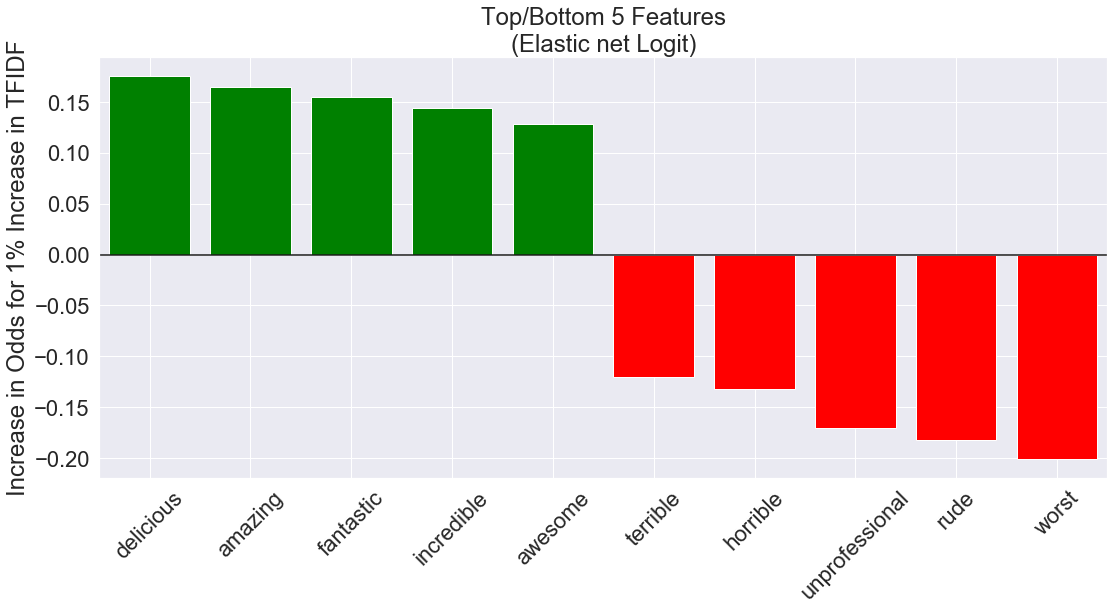

In [20]:
sns.set(font_scale=2)

n = 5
xs = np.arange(1, 2*n+1)
top_n_coef = np.exp(np.sort(lr['sgdclassifier'].coef_[0])[::-1][:n]/100) - 1
bot_n_coef = np.exp(np.sort(lr['sgdclassifier'].coef_[0])[:n][::-1]/100) - 1
bar_colors = np.concatenate((np.array(['green']*n), np.array(['red']*n)))
bar_labels = np.concatenate((np.array(features)[lr['sgdclassifier'].coef_[0].argsort()[:n]],np.array(features)[lr['sgdclassifier'].coef_[0].argsort()[-n:]]))[::-1]

fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
ax.bar(xs, np.concatenate((top_n_coef, bot_n_coef)), color=bar_colors)
offset = 0.5
ax.hlines(0, 1-offset, 10+offset)
ax.set(xlim=(1-offset, 10+offset), title=f'Top/Bottom {n} Features\n(Elastic net Logit)', 
       ylabel='Increase in Odds for 1% Increase in TFIDF')
plt.xticks(xs, bar_labels, rotation=45)
plt.savefig('../img/elasticnetlr_features.png')
plt.show()